In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
import time
import warnings
warnings.filterwarnings('ignore')
import importlib
import functions
from tqdm import tqdm
import spectral as sp

In [2]:
# data load
hdr = sp.envi.open("../data/Hyperspectral_Project/indian_pines.hdr")
wvl = hdr.bands.centers
rows, cols, bands = hdr.nrows, hdr.ncols, hdr.nbands
meta = hdr.metadata
img = hdr.load()
A = np.array(img)
N = np.array(A.shape)
print('Dimension of A:', N)

Dimension of A: [145 145 220]


In [5]:
# matrix unfoldings
A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
tmp = np.moveaxis(A,0,2) # 1 2 0
A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
tmp = np.moveaxis(A,2,0) # 2 0 1
A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])

In [6]:
# scree plot
scree = HOSVD_rank(A)

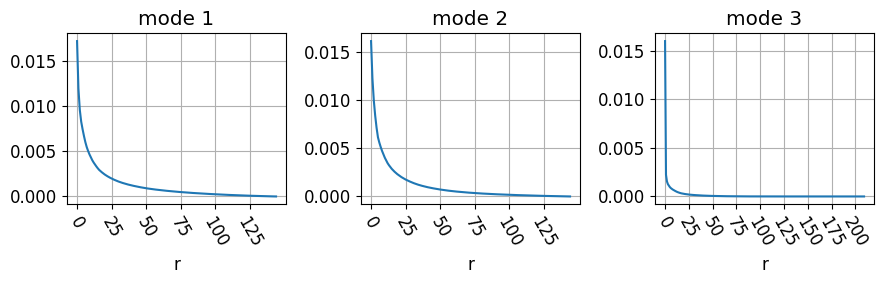

In [8]:
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(scree[0])
ax[0].set_title('mode 1')
ax[0].set_xlabel('r')
ax[0].set_xticks(np.arange(0, N[0], 25))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-60)
ax[0].grid()

ax[1].plot(scree[1])
ax[1].set_title('mode 2')
ax[1].set_xlabel('r')
ax[1].set_xticks(np.arange(0, N[1], 25),rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-60)
ax[1].grid()

ax[2].plot(scree[2])
ax[2].set_title('mode 3')
ax[2].set_xlabel('r')
ax[2].set_xticks(np.arange(0, N[2], 25))
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=-60)
ax[2].grid()
plt.tight_layout()
#plt.savefig('plots/hsi_screes.png',dpi=300)
plt.show()

In [9]:
# set the rank
r = np.array([25,25,5])

In [17]:
errs = []
times = []
for i in tqdm(range(100)):
    RP_HOSVD_err, RP_HOSVD_time = RP_HOSVD(A,A0,A1,A2,r)
    RP_STHOSVD_err, RP_STHOSVD_time = RP_STHOSVD(A,A0,A1,A2,r)
    R_PET_err, R_PET_time = R_PET(A,A0,A1,A2,r)
    R_ST_err, R_ST_time = R_ST(A,A0,A1,A2,r)
    R_HOID_err, R_HOID_time = R_HOID(A,A0,A1,A2,r)
    RP_HOOI_err, RP_HOOI_time = RP_HOOI(A,r,tol=10)
    R_SCTT_err, R_SCTT_time = R_SCTT(A,r,0.5)
    _, R_SCT_err, R_SCT_time = Random_SketchyCoreTucker(A,A0,A1,A2,r,300)
    _, P_SCT_err, m, P_SCT_time = pgSketchyCoreTucker(A,A0,A1,A2,r,10,30,300)
    errs.append([RP_HOSVD_err,RP_STHOSVD_err,R_PET_err,R_ST_err,R_HOID_err,RP_HOOI_err,R_SCTT_err,R_SCT_err,P_SCT_err])
    times.append([RP_HOSVD_time,RP_STHOSVD_time,R_PET_time,R_ST_time,R_HOID_time,RP_HOOI_time,R_SCTT_time,R_SCT_time,P_SCT_time])
errs = np.array(errs)
times = np.array(times)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:06<00:00,  8.47s/it]


In [18]:
print(np.mean(errs,axis=0))
print(np.std(errs,axis=0))
print(np.mean(times,axis=0))
print(np.std(times,axis=0))

[8.70739662e-03 3.17667742e-03 3.51655608e+00 8.43694213e-03
 7.39045741e-03 5.19305811e-03 1.47226542e-01 1.88081167e-01
 1.26431256e-02]
[0.39983567 1.14959589 0.85531502 0.07150765 0.66820825 0.64404229
 2.13189668 0.63147017 1.07254293]


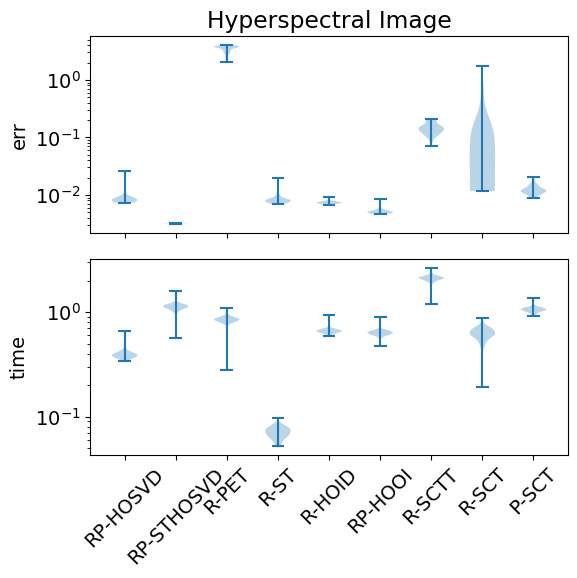

In [19]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(2,1,figsize=[6,6])
ax[0].violinplot(errs,vert=True)
ax[0].set_yscale('log')
ax[0].set_ylabel('err')
ax[0].set_xticks(range(1,10))
ax[0].set_xticklabels([])
ax[0].set_title('Hyperspectral Image')
ax[1].violinplot(times,vert=True)
ax[1].set_yscale('log')
ax[1].set_ylabel('time')
ax[1].set_xticks(range(1,10))
ax[1].set_xticklabels(['RP-HOSVD','RP-STHOSVD','R-PET','R-ST','R-HOID','RP-HOOI','R-SCTT','R-SCT','P-SCT'],rotation=45)
plt.tight_layout()
#plt.savefig('plots/hsi_error_AISTATS.png',dpi=300)
plt.show()

# Learning Curve

In [15]:
logPS_0, logPS_1, logPS_2 = pgskt_log(A,r,10,10,500)
err_logPS = lc(N,A,A0,A1,A2,r,logPS_0,logPS_1,logPS_2)

In [16]:
logRS_0, logRS_1, logRS_2 = rdskt_log(A,r,10,10,500)
err_logRS = lc(N,A,A0,A1,A2,r,logRS_0,logRS_1,logRS_2)

In [17]:
nf_PS = [len(i)+len(j)+len(k) for i,j,k in zip(logPS_0,logPS_1,logPS_2)]
nf_RS = [len(i)+len(j)+len(k) for i,j,k in zip(logRS_0,logRS_1,logRS_2)]

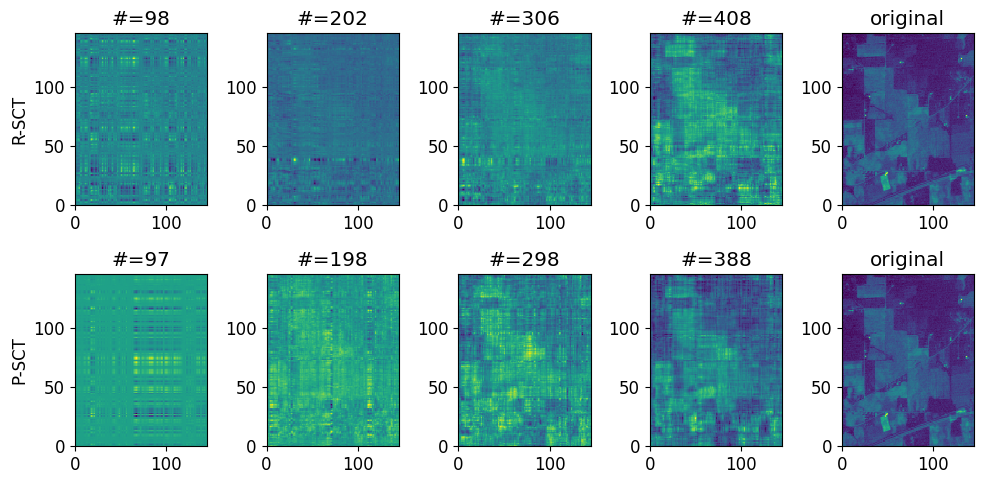

In [22]:
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(2,5,figsize=[10,5])

timestamps = [8,20,32,44]
band = 4

for i in range(4):
    ax[0,i].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[timestamps[i]],logRS_1[timestamps[i]],logRS_2[timestamps[i]])[:,:,band])
    ax[0,i].set_title('#=' + str(nf_RS[timestamps[i]]))
    ax[1,i].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[timestamps[i]],logPS_1[timestamps[i]],logPS_2[timestamps[i]])[:,:,band])
    ax[1,i].set_title('#=' + str(nf_PS[timestamps[i]]))

ax[0,0].set_ylabel('R-SCT')
ax[1,0].set_ylabel('P-SCT')

ax[0,4].pcolormesh(A[:,:,band])
ax[1,4].pcolormesh(A[:,:,band])
ax[0,4].set_title('original')
ax[1,4].set_title('original')

plt.tight_layout()
#plt.savefig('plots/hsi_Ar_AISTATS.png',dpi=300)
plt.show()